### 1) Implement a histogram equalization function. If using Matlab, compare your implementation with Matlab’s built-in function.

In [5]:
import numpy as np

def imhist(im):
    # Calculates normalized histogram of the image
    m, n = im.shape
    
    h = [0.0] * 256
    
    for i in range(m):
        for j in range(n):
            h[im[i, j]] += 1
            
    return np.array(h)/(m*n)

def cumsum(h):
    # finds the cumulative sum of a numpy array, list
    return [sum(h[:i+1]) for i in range(len(h))]

def histeq(im):
    
    # calculates histogram
    h = imhist(im)
    
    # cummulative distribution function
    cdf = np.array(cumsum(h))
    
    # Converting our histogram values into equalized values
    sk = np.uint8(255 * cdf)
    s1, s2 = im.shape
    Y = np.zeros_like(im)
    
    # Applying transformed values to each pixel
    for i in range(0, s1):
        for j in range(0, s2):
            Y[i, j] = sk[im[i, j]]
            
    H = imhist(Y)
    
    #return transformed image, original and new istogram, 
    # and transform function
    return Y, h, H, sk

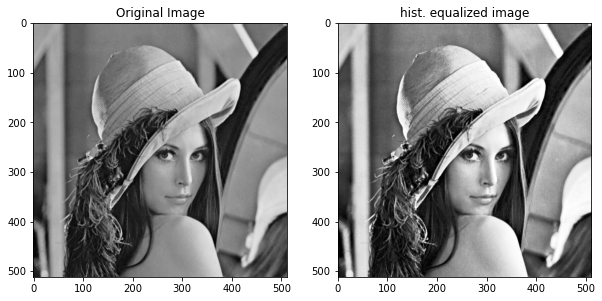

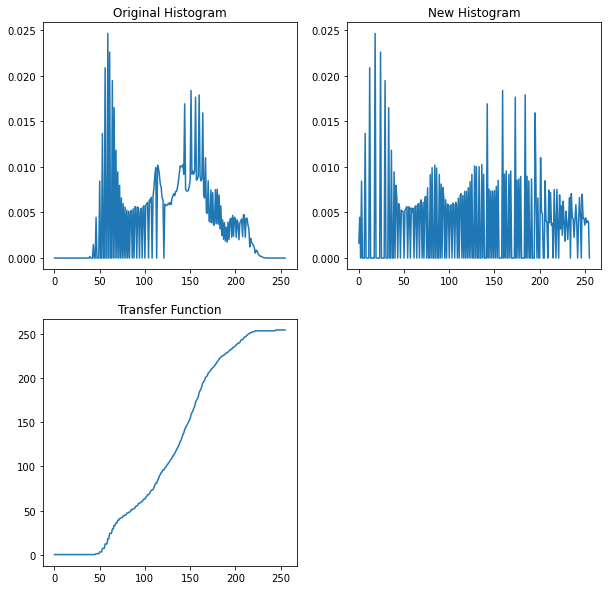

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('lena1.png', 0)

new_img, h, new_h, sk = histeq(img)

# Plotting the histograms and images

plt.figure(figsize=(10, 10))

# show original image
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.set_cmap('gray')

# show equalized original image
plt.subplot(122)
plt.imshow(new_img)
plt.title('hist. equalized image')
plt.set_cmap('gray')

# Plotting histograms and transfer functions
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(221)
plt.plot(h)
plt.title('Original Histogram')

fig.add_subplot(222)
plt.plot(new_h)
plt.title('New Histogram')

fig.add_subplot(223)
plt.plot(sk)
plt.title("Transfer Function")

plt.show()

### 2) Implement a median filter. Add different levels and types of noise to an image and experiment with different sizes of support for the median filter. As before, compare your implementation with Matlab’s.

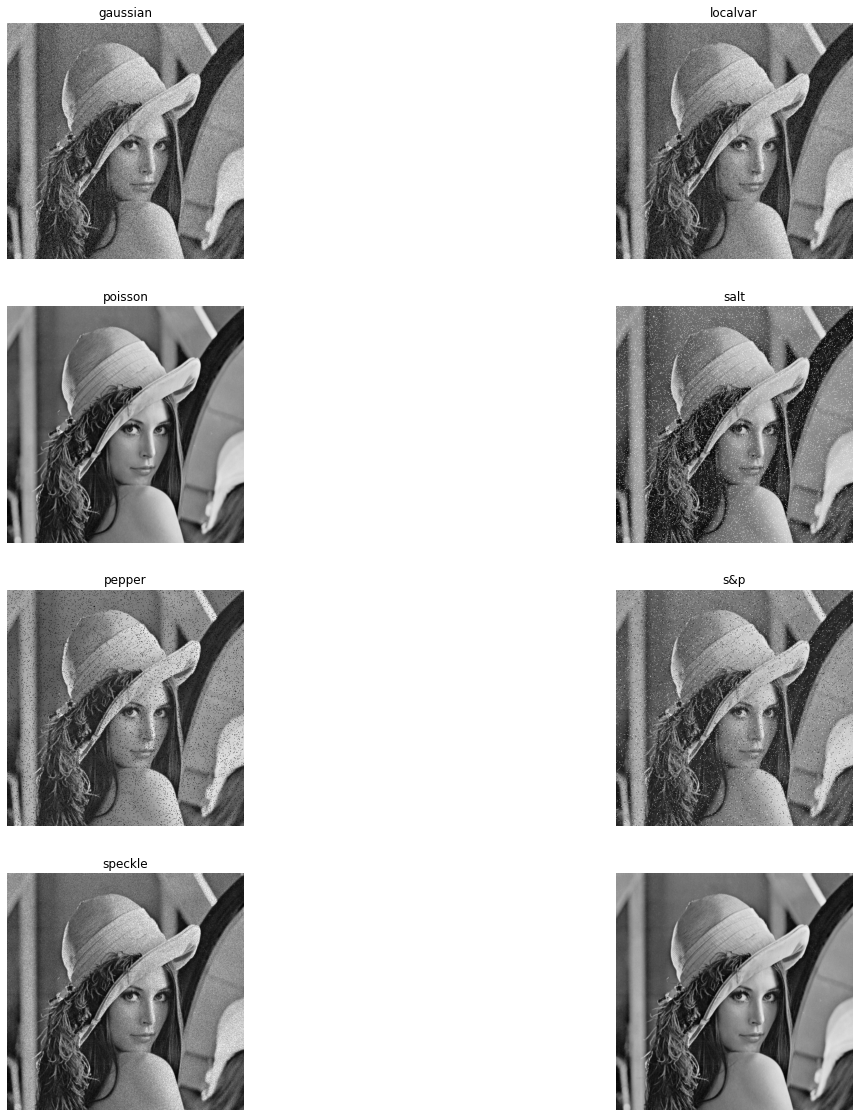

In [7]:
# Plotting noise using skimage

# link: https://gist.github.com/Prasad9/28f6a2df8e8d463c6ddd040f4f6a028a

import skimage
import matplotlib.pyplot as plt

img = skimage.io.imread('lena1.png', as_gray=True)#/255.0 # Normalizing the pixrl values between 0 and 1

def plotnoise(img, mode, r, c, i):
    
    plt.subplot(r, c, i)
    plt.set_cmap('gray')
    
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode=mode)
        plt.imshow(gimg)
        
    else:
        plt.imshow(img)
        
    plt.title(mode)
    plt.axis('off')
    
plt.figure(figsize=(20, 20))
r = 4
c = 2
plotnoise(img, "gaussian", r,c,1)
plotnoise(img, "localvar", r,c,2)
plotnoise(img, "poisson", r,c,3)
plotnoise(img, "salt", r,c,4)
plotnoise(img, "pepper", r,c,5)
plotnoise(img, "s&p", r,c,6)
plotnoise(img, "speckle", r,c,7)
plotnoise(img, None, r,c,8)
plt.show()

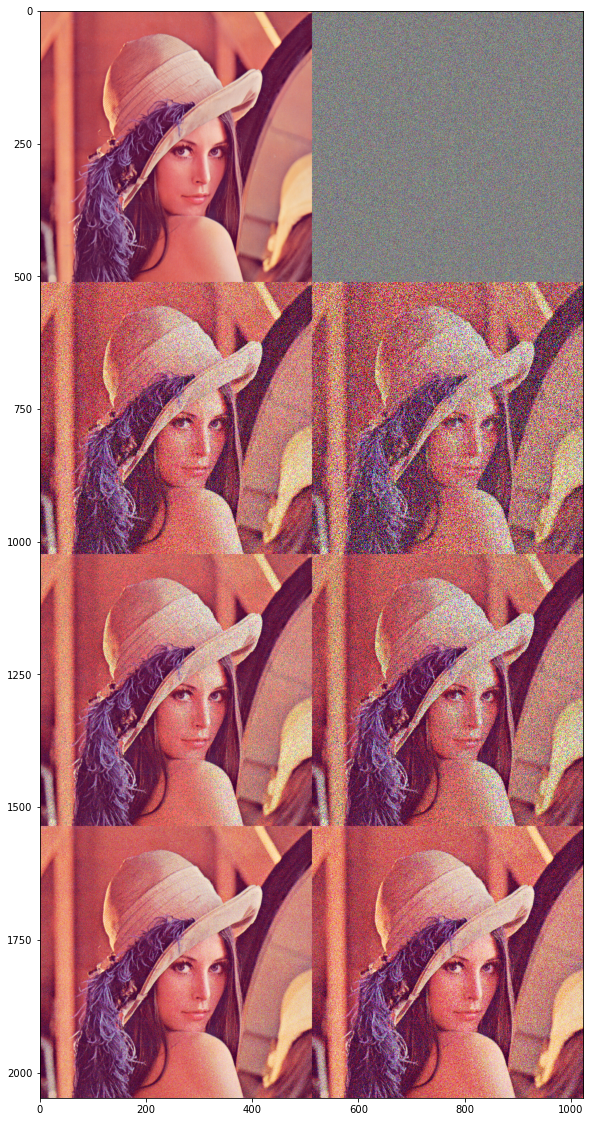

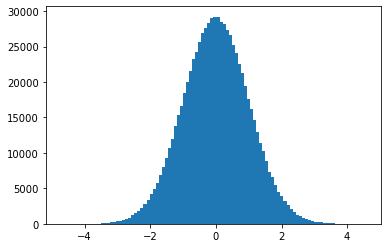

In [8]:
# Another example for adding noise

# gaussian noise added over image: noise is spread throughout
# gaussian noise multiplied then added over image: noise increases with image value
# image folded over and gaussian noise multipled and added to it: peak noise affects mid values, white and black receiving 
# ...little noise in every case i blend in 0.2 and 0.4 of the image

import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('lena1.png')[...,::-1]/255.0 # Normalizing pixels values between 0 and 1
noise = np.random.normal(loc=0, scale=1, size=img.shape)

# noise overlaid over image
noisy = np.clip((img + noise*0.2), 0, 1)
noisy2 = np.clip((img + noise*0.4), 0, 1)

# noise multiplied by image:
# whites can go black but blacks cannot go white
noisy2mul = np.clip((img*(1 + noise*0.2)), 0, 1)
noisy4mul = np.clip((img*(1 + noise*0.4)), 0, 1)

# noise multiplied by bottom and top half images
# whites stay white blacks black, noise is added to center
img2 = img*2 # Brightenes the image a little bit
n2 = np.clip(np.where(img2 <= 1, (img2*(1 + noise*0.2)), (1-img2+1)*(1 + noise*0.2)*-1 + 2)/2, 0, 1)
n4 = np.clip(np.where(img2 <= 1, (img2*(1 + noise*0.4)), (1-img2+1)*(1 + noise*0.4)*-1 + 2)/2, 0, 1)

# Normalizing noise only for visualization
noise2 = (noise - noise.min())/(noise.max() - noise.min())

plt.figure(figsize=(20, 20))
plt.imshow(np.vstack((np.hstack((img, noise2)),
                      np.hstack((noisy, noisy2)),
                      np.hstack((noisy2mul, noisy4mul)),
                      np.hstack((n2, n4)))))
plt.show()
plt.hist(noise.ravel(), bins=100)
plt.show()

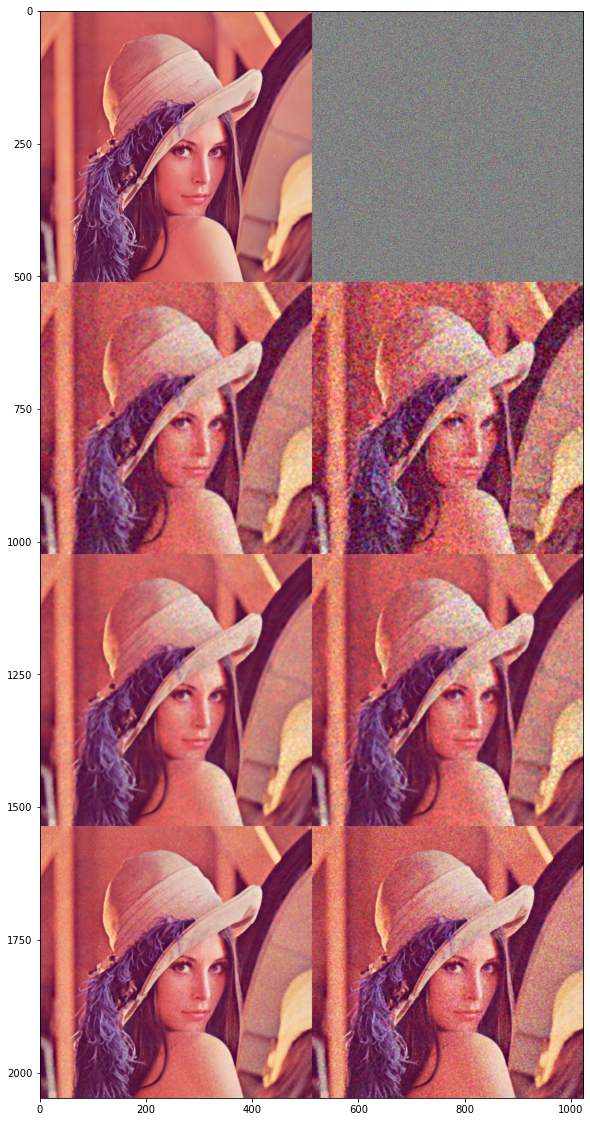

In [9]:
# Applying median filter
import cv2

plt.figure(figsize=(20, 20))

plt.imshow(np.vstack((np.hstack((img, noise2)),
                      np.hstack((cv2.medianBlur(noisy.astype('float32'), 5), cv2.medianBlur(noisy2.astype('float32'), 5))),
                      np.hstack((cv2.medianBlur(noisy2mul.astype('float32'), 5), cv2.medianBlur(noisy4mul.astype('float32'), 5))),
                      np.hstack((cv2.medianBlur(n2.astype('float32'), 3), cv2.medianBlur(n4.astype('float32'), 3))))))
plt.show()

### 3) Implement the non-local means algorithm. Try different window sizes. Add different levels of noise and see the influence of it in the need for larger or smaller neighborhoods. (Such block operations are easy when using Matlab, see for example the function at http://www.mathworks.com/help/images/ref/blockproc.html). Compare your results with those available in IPOL as demonstrated in the video lectures.

In [10]:
"""Parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
"""

import numpy as np
import os
import cv2

def noisy(noise_typ,image):
    if noise_typ == "gauss":
        
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    
    elif noise_typ == "s&p":
        
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    
    elif noise_typ == "poisson":
        
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    
    elif noise_typ =="speckle":
        
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


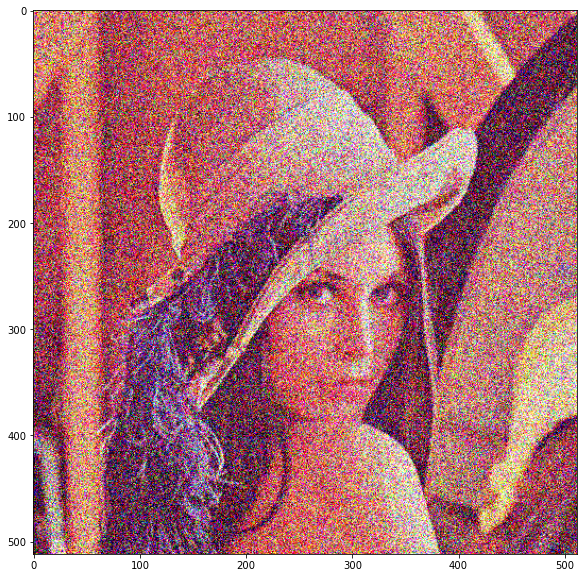

In [11]:
img = cv2.imread('lena1.png')/255.0
img_gauss = noisy('gauss', img)

plt.figure(figsize=(10, 10))

img_gauss_RGB = cv2.cvtColor(img_gauss.astype('float32'), cv2.COLOR_BGR2RGB)

plt.imshow(img_gauss_RGB)
plt.show()
#img

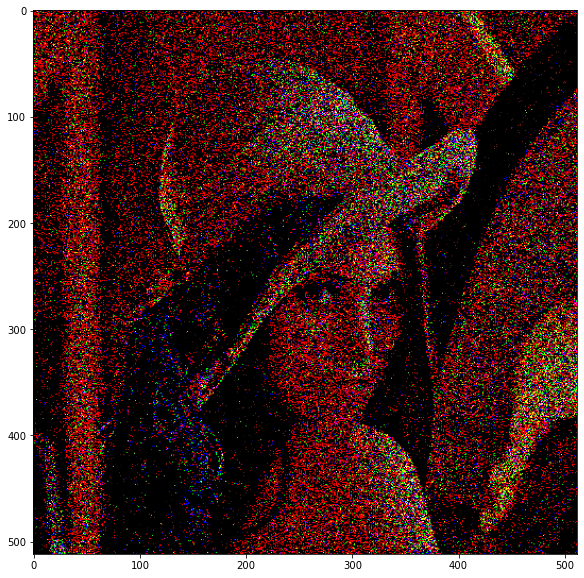

In [18]:
dst = cv2.fastNlMeansDenoisingColored(img_gauss.astype('uint8')*255, None, 10, 10, 7, 21)
plt.figure(figsize=(10, 10))

plt.imshow(dst[...,::-1])

0.31499351643319184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


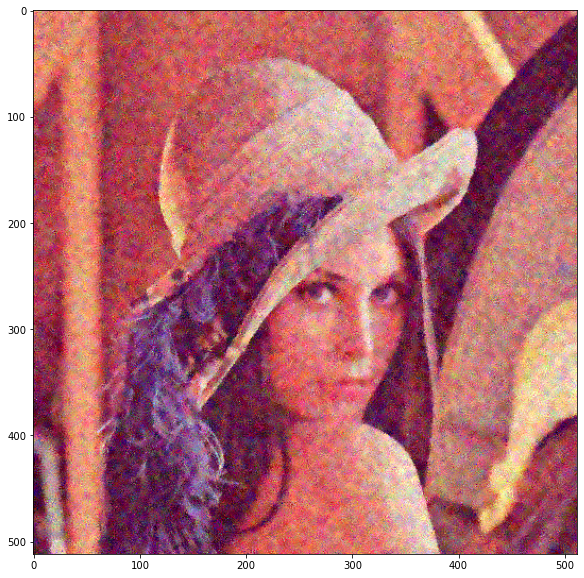

In [17]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

patch_kw = dict(patch_size=3,      # 5x5 patches
                patch_distance=3,  # 13x13 search area
                channel_axis=-1)

sigma = 0.08

sigma_est = np.mean(estimate_sigma(img_gauss, channel_axis=-1))
print(sigma_est)
denoise_fast = denoise_nl_means(img_gauss, h=1.15*sigma_est, fast_mode=False, **patch_kw)

plt.figure(figsize=(10, 10))
plt.imshow(denoise_fast[..., ::-1])

### 4) Implement the basic color edge detector. What happens when the 3 channels are equal?

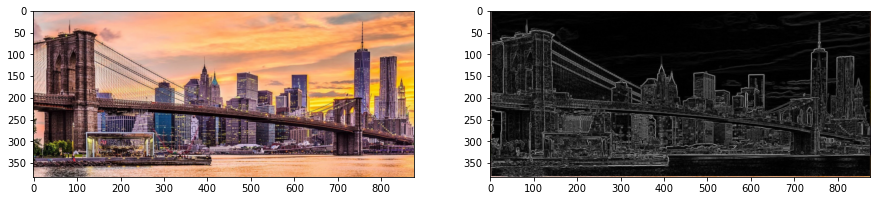

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the vertical filter
vertical_filter = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

# Define the horizontal filter
horizontal_filter = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# Reading the image
img = plt.imread('pinwheel.png')

n, m, d = img.shape

edges_img = img.copy()

# loop over all the pixels of the image
for row in range(3, n-2):
    for col in range(3, m-2):
        
        # Create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2, 0]
        
        # Apply the vertical filter
        vertical_transformed_pixels = vertical_filter*local_pixels
        
        # remap the vertical score
        vertical_score = vertical_transformed_pixels.sum()/4
        
        # Apply the horizontal filter
        horizontal_transformed_pixels = horizontal_filter*local_pixels
        
        # remap the horizontal score
        horizontal_score = horizontal_transformed_pixels.sum()/4
        
        # Combine the horizontal and vertical scores into a total edge score
        edge_score = (vertical_score**2 + horizontal_score**2)**0.5
        
        # Insert this edge score into the edge image
        edges_img[row, col] = [edge_score]*3
        
# remap the values in the edges image in the range {0-1} in case they got out of range
edges_img = edges_img/edges_img.max()

# displaying the images
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(edges_img)
plt.show()

### 5) Search for “camouflage artist Liu Bolin.” Do you think you can use the tools you are learning to detect him?

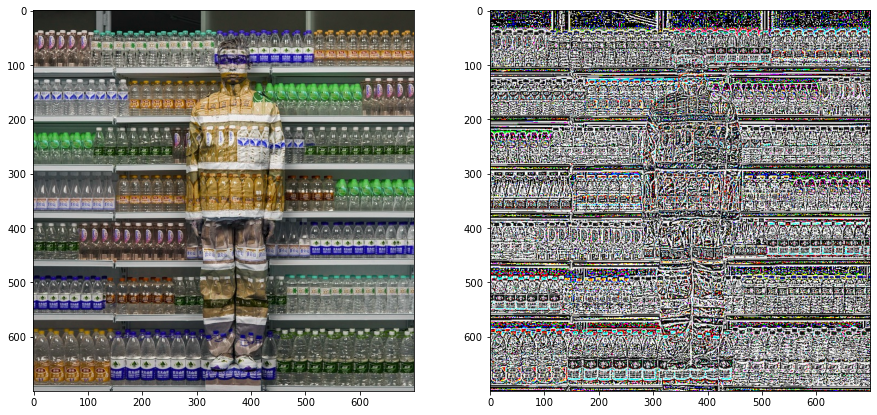

In [34]:
import cv2
import numpy as np

img = cv2.imread('liubolin.jpg')

# Blurring the image using gaussian blur
blur = cv2.GaussianBlur(img, (7, 7), 0)

diff = img - blur

diff = cv2.cvtColor(diff, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img)

plt.subplot(122)
plt.imshow(diff)
plt.show()